# Importing Libraries

In [2]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras.utils import to_categorical
from keras import models, layers
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D

# Hyperparameters

In [34]:
### IMAGE PREPROCESSING HYPERPARAMETERS

IMG_PATH = r"Images\1.jpg"
IMG_HEIGHT = 450
IMG_WIDTH = 450

### MODEL TRAINING HYPERPARAMETERS

# NUM_EPOCHS = 12
# BATCH_SIZE = 1000
MODEL_PATH = r"models\my_model_cnn.h5"

path = r"Dataset"
testRatio = 0.2
valRatio = 0.2
imageDimensions = (28, 28, 3)

batchSizeVal = 50
epochsVal = 40
stepsPerEpochVal = 6534//batchSizeVal

# Preprocessing

In [4]:
### Image Preprocessing

def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

def preProcess(img):
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray, (5, 5), 1)
    imgThreshold = cv2.adaptiveThreshold(imgBlur, 255, 1, 1, 11, 2)
    return imgThreshold

# Utility Functions

In [5]:
#### Reorder points for Warp Perspective
def reorder(myPoints):
    myPoints = myPoints.reshape((4, 2))
    myPointsNew = np.zeros((4, 1, 2), dtype=np.int32)
    add = myPoints.sum(1)
    myPointsNew[0] = myPoints[np.argmin(add)]
    myPointsNew[3] =myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    myPointsNew[1] =myPoints[np.argmin(diff)]
    myPointsNew[2] = myPoints[np.argmax(diff)]
    return myPointsNew

#### FINDING THE BIGGEST COUNTOUR ASSUMING THAT IS THE SUDOKU PUZZLE
def biggestContour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest,max_area

#### TO SPLIT THE IMAGE INTO 81 DIFFERENT IMAGES
def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes=[]
    for r in rows:
        cols= np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

#### DRAW GRID TO SEE THE WARP PRESPECTIVE EFFICENCY (OPTIONAL)
def drawGrid(img):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 0),2)
        cv2.line(img, pt3, pt4, (255, 255, 0),2)
    return img

def getPrediction(boxes, model):
    result = []
    for image in boxes:
        ## PREPARE THE IMAGE
        img = np.asarray(image)
        img = img[4:img.shape[0]-4, 4:img.shape[1]-4]
        img = cv2.resize(img, (28, 28))
        img = img/255
        img = img.reshape(1, 28, 28, 1)
        ## GET PREDICTION
        predictions = model.predict(img)
        classIndex = np.argmax(predictions, axis=-1)
        probabilityValue = np.amax(predictions) 
        # print(classIndex, probabilityValue)
        ## SAVE TO RESULT
        if probabilityValue > 0.6:
            result.append(classIndex[0])
        else:
            result.append(0)
    return result

#### TO DISPLAY THE SOLUTION ON THE IMAGE
def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                 cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img

#### TO STACK ALL THE IMAGES IN ONE WINDOW
def stackImages(imgArray,scale):
    rows = len(imgArray)
    cols = len(imgArray[0])
    rowsAvailable = isinstance(imgArray[0], list)
    width = imgArray[0][0].shape[1]
    height = imgArray[0][0].shape[0]
    if rowsAvailable:
        for x in range ( 0, rows):
            for y in range(0, cols):
                imgArray[x][y] = cv2.resize(imgArray[x][y], (0, 0), None, scale, scale)
                if len(imgArray[x][y].shape) == 2: imgArray[x][y]= cv2.cvtColor( imgArray[x][y], cv2.COLOR_GRAY2BGR)
        imageBlank = np.zeros((height, width, 3), np.uint8)
        hor = [imageBlank]*rows
        hor_con = [imageBlank]*rows
        for x in range(0, rows):
            hor[x] = np.hstack(imgArray[x])
            hor_con[x] = np.concatenate(imgArray[x])
        ver = np.vstack(hor)
        ver_con = np.concatenate(hor)
    else:
        for x in range(0, rows):
            imgArray[x] = cv2.resize(imgArray[x], (0, 0), None, scale, scale)
            if len(imgArray[x].shape) == 2: imgArray[x] = cv2.cvtColor(imgArray[x], cv2.COLOR_GRAY2BGR)
        hor= np.hstack(imgArray)
        hor_con= np.concatenate(imgArray)
        ver = hor
    return ver

# EDA and Dataloading

In [6]:
images = []
classNo = []
myList = os.listdir(path)
noOfClasses = len(myList)

for x in range(0, noOfClasses):
    myPicList = os.listdir(path+"/"+str(x))
    for y in myPicList:
        curImg = cv2.imread(path+"/"+str(x)+"/"+y)
        curImg = cv2.resize(curImg, (imageDimensions[0], imageDimensions[1]))
        images.append(curImg)
        classNo.append(x)
    print(x, end=" ")
print(" ")

0 1 2 3 4 5 6 7 8 9  


In [7]:
images = np.array(images)
classNo = np.array(classNo)
print(images.shape)

(10160, 28, 28, 3)


In [8]:
#### SPLITTING THE DATA
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=valRatio)

print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(6502, 28, 28, 3)
(2032, 28, 28, 3)
(1626, 28, 28, 3)


[664, 647, 659, 603, 653, 659, 673, 659, 630, 655]


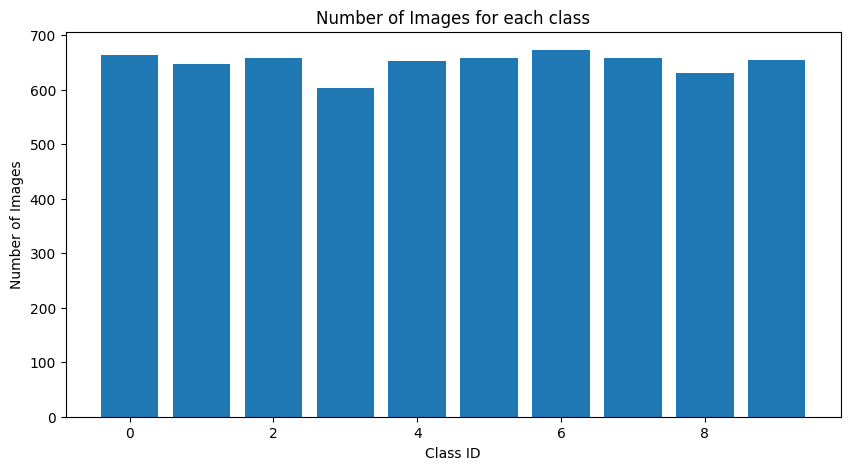

In [9]:
numOfSamples = []
for x in range(0, noOfClasses):
    numOfSamples.append(len(np.where(y_train == x)[0]))
print(numOfSamples)

plt.figure(figsize=(10,5))
plt.bar(range(0,noOfClasses), numOfSamples)
plt.title("Number of Images for each class")
plt.xlabel("Class ID")
plt.ylabel("Number of Images")
plt.show()

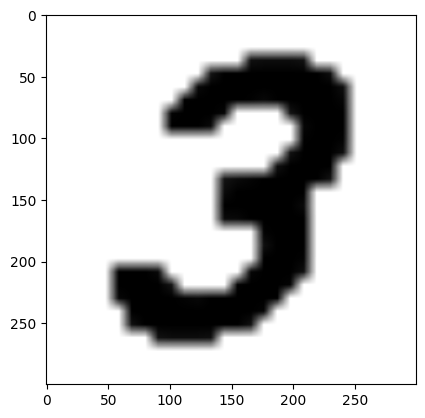

In [11]:
img = preProcessing(X_train[30])
img = cv2.resize(img, (300,300))

plt.imshow(img, cmap= "gray")
plt.show()

In [12]:
X_train = np.array(list(map(preProcessing, X_train)))
X_test = np.array(list(map(preProcessing, X_test)))
X_validation = np.array(list(map(preProcessing, X_validation)))

## Adding Depths
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], 
                                    X_validation.shape[2], 1)
X_train.shape # :=(6502, 32, 32, 1) ## All are Grayscale Images

(6502, 28, 28, 1)

In [13]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10
                            )
dataGen.fit(X_train)

## One Hot Encoding
y_train = to_categorical(y_train, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)

# Model Definition

In [14]:
def myModel():
    noOfFilters = 60
    sizeOfFilter1 = (5, 5)
    sizeOfFilter2 = (3, 3)
    sizeOfPool = (2, 2)
    noOfNode = 500

    model = Sequential()
    model.add(Conv2D(noOfFilters, sizeOfFilter1, input_shape=(imageDimensions[0],  
                                                                imageDimensions[1], 1),
                                                                activation='relu'))

    model.add(Conv2D(noOfFilters, sizeOfFilter1, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu'))
    model.add(Conv2D(noOfFilters//2, sizeOfFilter2, activation='relu'))
    model.add(MaxPooling2D(pool_size=sizeOfPool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(noOfNode, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

model = myModel()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 60)        90060     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 60)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 30)          16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 30)          8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 30)         0         
 2D)                                                    

C:\Users\ASUS\AppData\Roaming\Python\Python38\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
## Only if you dont want to train the model again.

model.load_weights(r"models\my_model_cnn.h5")

# Training and Evaluation

C:\Users\ASUS\AppData\Local\Temp\ipykernel_13400\240060712.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(dataGen.flow(X_train, y_train, batch_size=batchSizeVal), steps_per_epoch=stepsPerEpochVal, epochs=epochsVal, validation_data=(X_validation, y_validation), shuffle=1)


Epoch 1/50
130/130 [==============================] - 15s 28ms/step - loss: 1.6069 - accuracy: 0.4175 - val_loss: 0.2542 - val_accuracy: 0.9446
Epoch 2/50
130/130 [==============================] - 3s 21ms/step - loss: 0.6472 - accuracy: 0.7894 - val_loss: 0.1316 - val_accuracy: 0.9588
Epoch 3/50
130/130 [==============================] - 3s 20ms/step - loss: 0.4385 - accuracy: 0.8548 - val_loss: 0.0781 - val_accuracy: 0.9766
Epoch 4/50
130/130 [==============================] - 3s 19ms/step - loss: 0.3556 - accuracy: 0.8842 - val_loss: 0.0632 - val_accuracy: 0.9809
Epoch 5/50
130/130 [==============================] - 3s 19ms/step - loss: 0.2808 - accuracy: 0.9090 - val_loss: 0.0512 - val_accuracy: 0.9877
Epoch 6/50
130/130 [==============================] - 3s 19ms/step - loss: 0.2565 - accuracy: 0.9228 - val_loss: 0.0595 - val_accuracy: 0.9809
Epoch 7/50
130/130 [==============================] - 3s 20ms/step - loss: 0.2108 - accuracy: 0.9306 - val_loss: 0.0337 - val_accuracy: 0.990

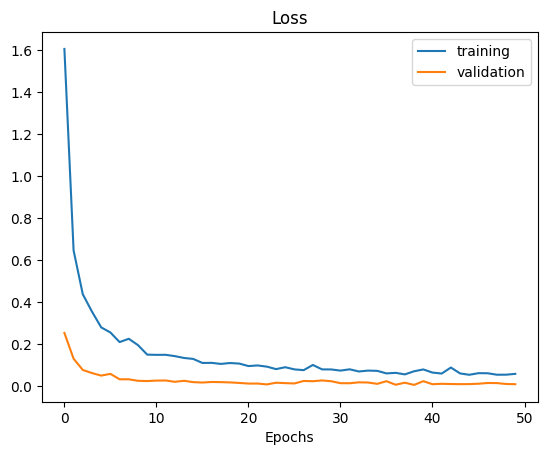

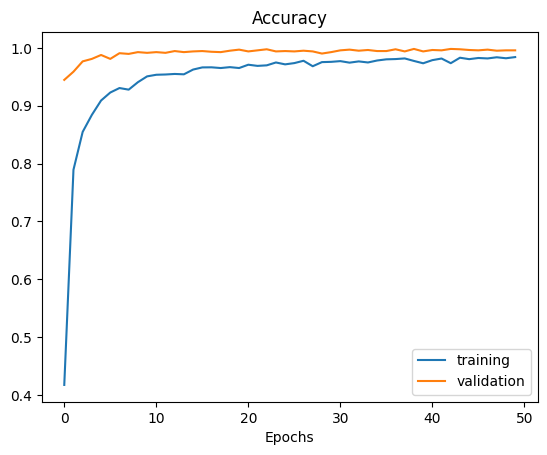

In [14]:
###TRAINING THE MODEL
history = model.fit_generator(dataGen.flow(X_train, y_train, batch_size=batchSizeVal), steps_per_epoch=stepsPerEpochVal, epochs=epochsVal, validation_data=(X_validation, y_validation), shuffle=1)

## Plotting
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epochs')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epochs')

plt.show()

In [15]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score = ', score[0])
print('Test Accuracy =', score[1])

### SAVING THE MODEL 
model.save('models\my_model_cnn.h5')

Test Score =  0.013811666518449783
Test Accuracy = 0.9945865869522095


# Sudoku Solver Algorithm

In [16]:
#### SUDOKU SOLVING ALGORITHM
# We know that sudoku is a 9x9 2D matrix

def foundInCol(arr, col, num):  # Checks if num is aldready present in the column
    for i in range(9):
      if(arr[i][col] == num):
        return True
    return False


def foundInRow(arr, row, num):  # Checks if num is aldready present in the row
    for i in range(9):
      if(arr[row][i] == num):
        return True
    return False


def foundInBox(arr, row, col, num): # Checks if the num exists in the 3x3 grid
    startRow = row - (row % 3)
    startCol = col - (col % 3)
    for i in range(3):
      for j in range(3):
        if(arr[i + startRow][j + startCol] == num):
          return True
    return False

def isSafe(arr, row, col, num):
    return ((not foundInRow(arr, row, num)) and (not foundInCol(arr, col, num)) and (not foundInBox(arr, row, col, num)))

def foundEmptyCell(arr, loc): # Finds the location of the next empty cell 
    for i in range(9):
      for j in range(9):
        if(arr[i][j] == 0):
          loc[0] = i  # loc[0] will give the empty cell row
          loc[1] = j  # loc[1] will give the empty cell column
          return True
    return False

def solveSudoku(arr):

    l = [0,0]

    if(not foundEmptyCell(arr, l)): # Returns True when all spaces are filled by us
        return True

    row = l[0]  # Assigns the empty location
    col = l[1]  # got from the above function

    for num in range(1, 10):
        if(isSafe(arr, row, col, num)):
            arr[row][col] = num
            if(solveSudoku(arr)):
                return True
            arr[row][col] = 0       # If a num is safe, but there doesn't exist a solution with it; the location must be set to 0 for further iterations of num 

    return False  # Backtracking

# Making Predictions

In [35]:
pathImage = IMG_PATH
heightImg = IMG_HEIGHT
widthImg = IMG_WIDTH
pathImage

'Images\\1.jpg'

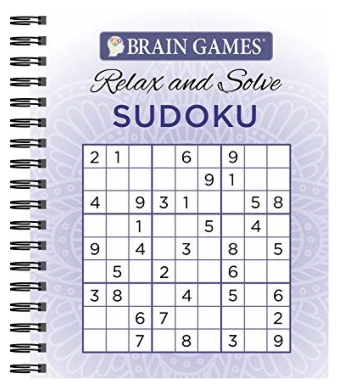

In [36]:
#### PREPARE THE IMAGE
img = cv2.imread(pathImage)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)

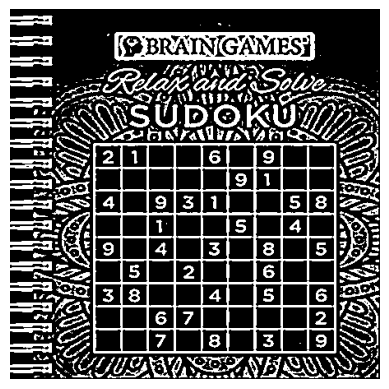

In [37]:
img = cv2.resize(img, (widthImg, heightImg))  # RESIZE IMAGE TO MAKE IT A SQUARE IMAGE
imgBlank = np.zeros((heightImg, widthImg, 3), np.uint8)  # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
imgThreshold = preProcess(img)
plt.axis('off')
plt.imshow(imgThreshold, cmap="gray")

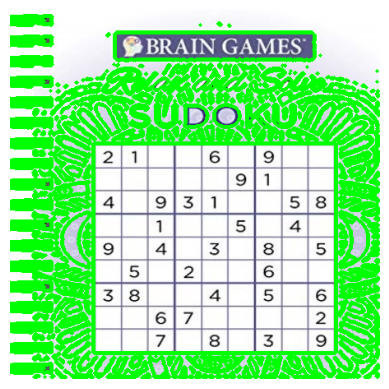

In [38]:
#### FIND ALL COUNTOURS
imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 3) # DRAW ALL DETECTED CONTOURS
plt.axis('off')
plt.imshow(imgContours, cmap="gray")

In [39]:
#### FIND THE BIGGEST COUNTOUR AND USE IT AS SUDOKU
biggest, maxArea = biggestContour(contours) # FIND THE BIGGEST CONTOUR
print(biggest)

[[[101 164]]

 [[102 418]]

 [[396 417]]

 [[396 164]]]


In [40]:
if biggest.size != 0:
    biggest = reorder(biggest)
    print(biggest)

else:
    print("No Sudoku Found")

[[[101 164]]

 [[396 164]]

 [[102 418]]

 [[396 417]]]


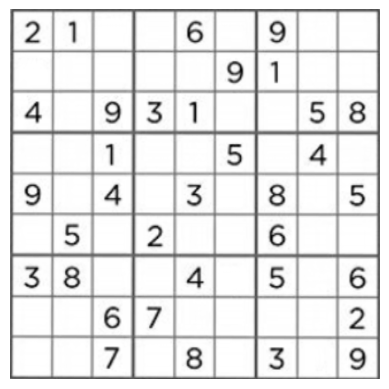

In [41]:
cv2.drawContours(imgBigContour, biggest, -1, (0, 0, 255), 25)
pts1 = np.float32(biggest)
pts2 = np.float32([[0, 0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])
matrix = cv2.getPerspectiveTransform(pts1, pts2)
imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))
imgWarpGrayed = cv2.cvtColor(imgWarpColored, cv2.COLOR_BGR2GRAY)
imgDetectedDigits = imgBlank.copy()
plt.axis('off')
plt.imshow(imgWarpGrayed, cmap="gray")

In [42]:
#### SPLIT THE WARPED SUDOKU IMAGE AND PREDICT THE DIGITS
imgSolvedDigits = imgBlank.copy()
boxes = splitBoxes(imgWarpGrayed)
print(boxes[0].shape) # := (50, 50)

(50, 50)


In [43]:
numbers = getPrediction(boxes, model)
print(numbers)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step
[2, 1, 0, 0, 6, 0, 9, 0, 0, 0, 0, 0, 0, 0, 9, 1, 0, 0, 4, 0, 9, 3, 1, 0, 0, 5, 8, 0, 0, 1, 0, 0, 5, 0, 4, 0, 9, 0, 4, 0, 3, 0, 8, 0, 5, 0, 5, 0, 2, 0, 0, 6, 0, 0, 3, 8, 0, 0, 4, 0, 5, 0, 6, 0, 0, 6, 7, 0, 0, 0, 0, 2, 0, 0, 7, 0, 8, 0, 3, 0, 9]


In [44]:
imgDetectedDigits = displayNumbers(imgDetectedDigits, numbers, color=(255, 0, 255))
numbers = np.asarray(numbers)
posList = np.where(numbers > 0, 0, 1) # Set bit at blank spaces 

In [45]:
#### SOLVE
board = np.reshape(numbers, (9, 9))
print(board)

[[2 1 0 0 6 0 9 0 0]
 [0 0 0 0 0 9 1 0 0]
 [4 0 9 3 1 0 0 5 8]
 [0 0 1 0 0 5 0 4 0]
 [9 0 4 0 3 0 8 0 5]
 [0 5 0 2 0 0 6 0 0]
 [3 8 0 0 4 0 5 0 6]
 [0 0 6 7 0 0 0 0 2]
 [0 0 7 0 8 0 3 0 9]]


In [46]:
if(solveSudoku(board)):
    solvedBoard = board
else:
    print("Error")

print(solvedBoard)

[[2 1 5 4 6 8 9 3 7]
 [7 3 8 5 2 9 1 6 4]
 [4 6 9 3 1 7 2 5 8]
 [6 2 1 8 9 5 7 4 3]
 [9 7 4 1 3 6 8 2 5]
 [8 5 3 2 7 4 6 9 1]
 [3 8 2 9 4 1 5 7 6]
 [1 9 6 7 5 3 4 8 2]
 [5 4 7 6 8 2 3 1 9]]


In [47]:
solvedBoardFlattened = []
for subarr in solvedBoard:
    for item in subarr:
        solvedBoardFlattened.append(item)

solvedNumbers = solvedBoardFlattened*posList
imgSolvedDigits = displayNumbers(imgSolvedDigits, solvedNumbers, (0, 255, 0))

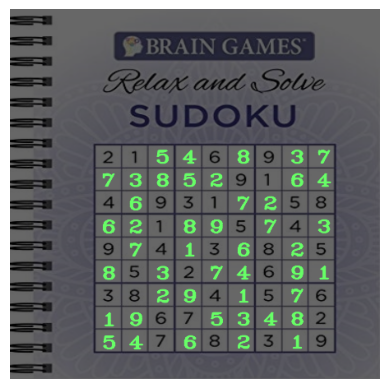

In [48]:
#### OVERLAYING THE SOLUTION
pts1 = np.float32([[0, 0], [widthImg, 0], [0, heightImg], [widthImg, heightImg]])
pts2 = np.float32(biggest)

imgInvWarped = img.copy()
invMatrix = cv2.getPerspectiveTransform(pts1, pts2)
imgInvWarped = cv2.warpPerspective(imgSolvedDigits, invMatrix, (widthImg, heightImg))
imgOverlayed = cv2.addWeighted(imgInvWarped, 1, img, 0.4, 1)

plt.axis('off')
plt.imshow(imgOverlayed)

In [49]:
#### Saving the solved sudoku image

filename = r"Images\solved1.jpg"
  
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, imgOverlayed)

True